In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the input file from local computer
path = '/content/drive/MyDrive/comb.img'
with open(path, 'rb') as file:
    data = file.read()

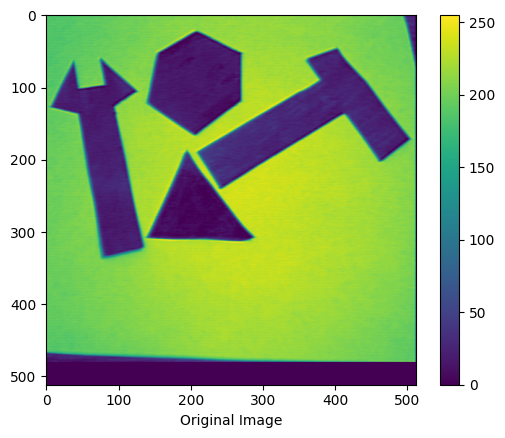

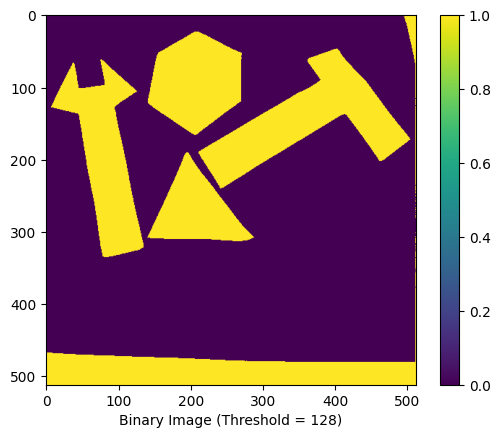

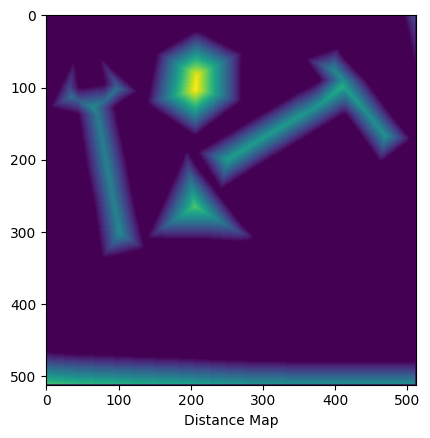

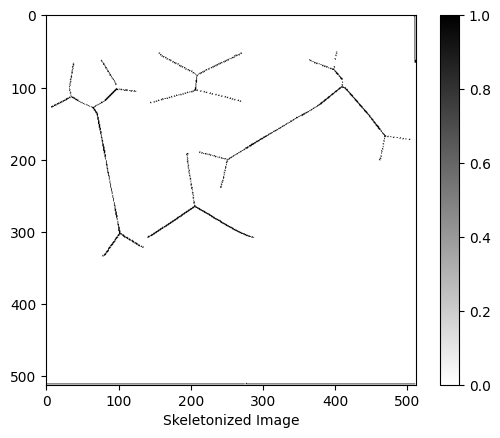

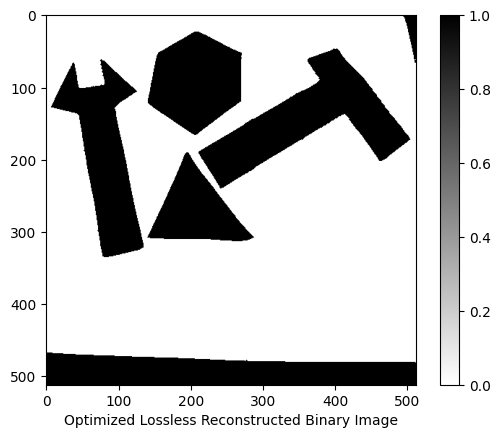

In [ ]:
#importing libraries

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.ndimage import label as nd_label, sum as ndi_sum, center_of_mass, find_objects
import math

# Read the image from comb.img file and strip the 512-byte header
input_file = '/content/drive/MyDrive/comb.img'
shape = (512, 512)  # matrix size
dtype = np.uint8

#Stripping the 512 header
with open(input_file, 'rb') as bf:
    bf.seek(512)  # stripping the 512-size header in front
    data = np.fromfile(bf, dtype)
    image = data.reshape(shape)  # reshape the image as 2D array of 512 pixels and load the image

# Display Original Image
plt.imshow(image)
plt.xlabel("Original Image")
plt.colorbar()
plt.show()

# Creating Binary Image with a Threshold value of 128
threshold = 128
binary_image = image < threshold

# Display Binary Image
plt.imshow(binary_image)
plt.xlabel("Binary Image (Threshold = 128)")
plt.colorbar()
plt.show()



# Create a temporary binary image to remove boundary pixels
binary_image = np.array(binary_image, dtype=np.int8)
# Initialize distance_map where foreground pixels are 1 and background pixels are 0
distance_map = np.where(binary_image == 1, 1, 0)

#Initialize rows and cols as binary image shape
rows, cols = binary_image.shape  # Extract dimensions properly


queue = deque()

# Initialize queue with boundary pixels
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if binary_image[i, j]:
            distance_map[i, j] = np.iinfo(np.int32).max  # Max int value
            # Check if the pixel has at least one background neighbor
            if (not binary_image[i - 1, j] or not binary_image[i + 1, j] or
                not binary_image[i, j - 1] or not binary_image[i, j + 1]):
                distance_map[i, j] = 1  # Set boundary pixel distance to 1
                queue.append((i, j))

# Neighbor offsets for 4-connectivity
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Process queue for distance transform
while queue:
    i, j = queue.popleft()
    current_distance = distance_map[i, j]
    for di, dj in neighbors:
        ni, nj = i + di, j + dj
        # Checking if pixel is within bounds and is a foreground pixel
        if (1 <= ni < rows - 1 and 1 <= nj < cols - 1 and binary_image[ni, nj]):
           # Update distance if a shorter path is found
            if distance_map[ni, nj] > current_distance + 1:
                distance_map[ni, nj] = current_distance + 1
                queue.append((ni, nj))

# Display Distance Transform
plt.imshow(distance_map, cmap='viridis')
plt.xlabel("Distance Map")
plt.show()

# Skeletonization using Distance Transform
skeletonized_image = np.zeros_like(binary_image, dtype=np.int8)

# Iterate over each pixel and compare with neighbors
for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        if binary_image[i, j]:
          # Compute the maximum distance value among neighboring pixels
            max_neighbor_distance = max(distance_map[i + di, j + dj] for di, dj in neighbors)
            #If current pixel has higehst distance, keep it as part of skeleton
            if distance_map[i, j] >= max_neighbor_distance:
                skeletonized_image[i, j] = distance_map[i, j]
                #Checking if neighbors have similar distance if yes, then they are kept, else they are initialize to 0
                for di, dj in neighbors:
                    ni, nj = i + di, j + dj
                    if distance_map[ni, nj] >= max_neighbor_distance:
                        skeletonized_image[ni, nj] = distance_map[i, j]
                    else:
                        skeletonized_image[ni, nj] = 0

# Display Skeletonized Image
image_plot = plt.imshow(skeletonized_image > 0, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel("Skeletonized Image")
plt.show()

# Assuming the locations of the medial axis pixels and distance values are extracted from the skeletonization process.

# Taking locations of the medial axis pixels as input to reconstruction image
medial_axis_pixels = [(i, j) for i in range(1, rows - 1) for j in range(1, cols - 1) if skeletonized_image[i, j] > 0]

# Taking distance transform values for those medial axis pixels also as input for reconstruction image
distance_values = [distance_map[i, j] for i, j in medial_axis_pixels]

# Initialize the reconstructed binary image with background (0)
reconstructed_image = np.zeros_like(binary_image, dtype=np.int8)

# Creating a copy of the skeletonized image
skeleton_copy = np.copy(skeletonized_image)


rows, cols = binary_image.shape

# Define 4-connectivity neighbors
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Collect initial skeleton pixels for processing
current_pixels = medial_axis_pixels

# Process only relevant pixels iteratively
while current_pixels:
    new_current_pixels = []  # Track newly assigned pixels
    for i, j in current_pixels:
        for di, dj in neighbors:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols:
                # Expand only if the pixel is unassigned or has a lower distance
                if ~(skeleton_copy[ni, nj] == 0 or skeleton_copy[ni, nj] < skeleton_copy[i, j] - 1):
                  pass
                else:
                    skeleton_copy[ni, nj] = skeleton_copy[i, j] - 1
                    if skeleton_copy[ni, nj] > 0:  # Continue processing if valid
                        new_current_pixels.append((ni, nj))

    # Update the active pixels for the next iteration
    current_pixels = new_current_pixels

# Assign reconstructed pixels based on nonzero values in the skeleton copy
reconstructed_image[skeleton_copy > 0] = 1

# Display the Reconstructed Binary Image
plt.imshow(reconstructed_image, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar()
plt.xlabel("Optimized Lossless Reconstructed Binary Image")
plt.show()